<a href="https://colab.research.google.com/github/MonicaSai7/CNN-on-pubfig83/blob/master/CNN_pubfig83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
import numpy as np
import tensorflow as tf
#!unzip pubfig83 

In [0]:
# Run this cell to mount your Google Drive.
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
def get_image_flt(image_path):
    image = cv2.imread(image_path, -1)
    return image.flatten()

In [0]:
def get_subjects(dataset_path):
    return os.listdir(dataset_path)

In [0]:
def get_images(subject_path):
    return os.listdir(subject_path)

In [0]:
def read_data(dataset_path):
    data = np.zeros((13838, 100*100*3))
    labels = dict()
    index = 0
    
    subjects = get_subjects(dataset_path)
    #print(subjects)
    for subject in subjects:
        #print(subject)
        subject_path = dataset_path + "//" + subject
        image_list = get_images(subject_path)
        
        for image in image_list:
            image_path = subject_path + "//" + image
            data[index, :] = get_image_flt(image_path)
            labels[index] = subject
            index += 1
    
    return data, labels

In [0]:
def array_to_image(image):
    return np.reshape(image, (100,100,3))

In [0]:
dataset_path = "pubfig83/"
X, labels = read_data(dataset_path)

**Get data**

In [0]:
#dataset = pd.read_csv('drive/My Drive/Colab Notebooks/pubfig83.csv')

import pandas as pd
#labels = pd.read_csv('drive/My Drive/Colab Notebooks/labels.csv')
#y = list(labels.keys())
y = pd.DataFrame({"Target":list(labels.values())})

**Check sample image**

In [0]:
i = array_to_image(X[2000,:])

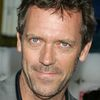

Target    Hugh Laurie
Name: 2000, dtype: object

In [10]:
from google.colab.patches import cv2_imshow
cv2_imshow(i)
#y_names[2000]
y.iloc[2000,:]

**Encode Categorical Variable - Class**

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_encodings = y.apply(le.fit_transform)

**Train and Test Split**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encodings, test_size = 0.2, random_state = 42)

In [0]:
del X

**Scaling Pixels**

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Train
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# Test
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

feature_columns = [tf.feature_column.numeric_column('x', shape = X_train_scaled.shape[1:])]


In [15]:
len(X_train_scaled)

11070

**Model Definition**

In [0]:
def cnn_model_fn(features, labels, mode):
    #print("Entered")
    """Model function for CNN."""
  # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 100, 100, 3])
    #print("1")

  # Convolutional Layer
    conv1 = tf.layers.conv2d( inputs=input_layer, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    #print("2")
  # Pooling Layer
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    #print("3")

  # Convolutional Layer #2 and Pooling Layer
    conv2 = tf.layers.conv2d( inputs=pool1, filters=36, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    #print("4")
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    #print("5")

  # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 25 * 25 * 36])
    #print("6")
    dense = tf.layers.dense(inputs=pool2_flat, units=25 * 25 * 36, activation=tf.nn.relu)
    #print("7")
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    #print("8")

  # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)
   # print("9")

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics Evaluation mode
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

**Estimator**

In [0]:
# Create the Estimator
pubfig_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="train/pubfig_convnet_model")

**Predictions log**

In [0]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

**Train Model**

In [0]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train_scaled},
    y=y_train.values,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

In [0]:
pubfig_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

W0708 11:20:36.078808 140146227369856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0708 11:20:36.101541 140146227369856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0708 11:20:36.104342 140146227369856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_functions.py:500: add_

**Evaluate Model**

In [0]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test_scaled},
    y=y_test.values,
    num_epochs=1,
    shuffle=False)
eval_results = pubfig_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

**Save data and labels as CSV files**


In [0]:
import csv

with open('labels.csv', 'w') as f:
    for key in labels.keys():
        f.write("%s,%s\n"%(key,labels[key]))

In [0]:
np.savetxt("pubfig83.csv", data, delimiter=",")

**Download saved CSV files**

In [0]:
from google.colab import files
files.download('pubfig83.csv')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 41614, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil